# Final Detecting Code

# Part 1 - Uploading Dependecies and Paths

In [1]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
from PIL import Image
import easyocr
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import webbrowser

%matplotlib inline

In [2]:
TAIL_MODEL_NAME = 'my_ssd_mobnet' 
CODE_MODEL_NAME = 'my_ssd_mobnet' 
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths_Tail = {
    'WORKSPACE_TAIL_PATH': os.path.join('tail_model','Tensorflow', 'workspace'),
    'SCRIPTS_TAIL_PATH': os.path.join('tail_model','Tensorflow','scripts'),
    'APIMODEL_TAIL_PATH': os.path.join('tail_model','Tensorflow','models'),
    'ANNOTATION_TAIL_PATH': os.path.join('tail_model','Tensorflow', 'workspace','annotations'),
    'IMAGE_TAIL_PATH': os.path.join('tail_model','Tensorflow', 'workspace','images'),
    'MODEL_TAIL_PATH': os.path.join('tail_model','Tensorflow', 'workspace','models'),
    'PRETRAINED_TAIL_MODEL_PATH': os.path.join('tail_model','Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_TAIL_PATH': os.path.join('tail_model','Tensorflow', 'workspace','models', TAIL_MODEL_NAME), 
    'OUTPUT_TAIL_PATH': os.path.join('tail_model','Tensorflow', 'workspace','models',TAIL_MODEL_NAME, 'export'), 
    'TFJS_TAIL_PATH':os.path.join('tail_model','Tensorflow', 'workspace','models',TAIL_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_TAIL_PATH':os.path.join('tail_model','Tensorflow', 'workspace','models',TAIL_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_TAIL_PATH':os.path.join('tail_model','Tensorflow','protoc')
 }
paths_Code = {
    'WORKSPACE_CODE_PATH': os.path.join('code_model','Tensorflow', 'workspace'),
    'SCRIPTS_CODE_PATH': os.path.join('code_model','Tensorflow','scripts'),
    'APIMODEL_CODE_PATH': os.path.join('code_model','Tensorflow','models'),
    'ANNOTATION_CODE_PATH': os.path.join('code_model','Tensorflow', 'workspace','annotations'),
    'IMAGE_CODE_PATH': os.path.join('code_model','Tensorflow', 'workspace','images'),
    'MODEL_CODE_PATH': os.path.join('code_model','Tensorflow', 'workspace','models'),
    'PRETRAINED_CODE_MODEL_PATH': os.path.join('code_model','Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_CODE_PATH': os.path.join('code_model','Tensorflow', 'workspace','models', CODE_MODEL_NAME), 
    'OUTPUT_CODE_PATH': os.path.join('code_model','Tensorflow', 'workspace','models',CODE_MODEL_NAME, 'export'), 
    'TFJS_CODE_PATH':os.path.join('code_model','Tensorflow', 'workspace','models',CODE_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_CODE_PATH':os.path.join('code_model','Tensorflow', 'workspace','models',CODE_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_CODE_PATH':os.path.join('code_model','Tensorflow','protoc')
 }

In [4]:
files_Tail = {
    'PIPELINE_TAIL_CONFIG':os.path.join('tail_model','Tensorflow', 'workspace','models', TAIL_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT_TAIL': os.path.join(paths_Tail['SCRIPTS_TAIL_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP_TAIL': os.path.join(paths_Tail['ANNOTATION_TAIL_PATH'], LABEL_MAP_NAME)
}
files_Code = {
    'PIPELINE_CODE_CONFIG':os.path.join('code_model','Tensorflow', 'workspace','models', CODE_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT_CODE': os.path.join(paths_Code['SCRIPTS_CODE_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP_CODE': os.path.join(paths_Code['ANNOTATION_CODE_PATH'], LABEL_MAP_NAME)
}

# Loading the Tail Decting Model

In [5]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files_Tail['PIPELINE_TAIL_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths_Tail['CHECKPOINT_TAIL_PATH'], 'ckpt-4')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(files_Tail['LABELMAP_TAIL'])

Deallocating memory
[0.206866   0.04614708 0.568588   0.5452881 ]
[224.0358738   73.83532524 615.78082395 872.4609375 ]
Counter is  1
Saving the image
Counter after adding is  2


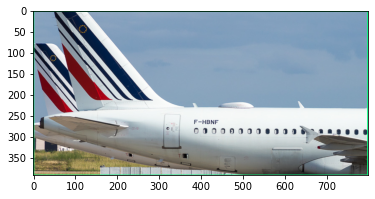

In [7]:
counter = 1
for filename in os.listdir('input'):
    
    IMAGE_PATH = os.path.join('input', filename)
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)
    
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    detection_threshold = 0.7

    image = image_np_with_detections
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]

    
    width = image.shape[1]
    height = image.shape[0]
    # Apply ROI filtering and OCR
    print('Deallocating memory')

            
    for idx, box in enumerate(boxes):
        print(box)
        roi = box*[height, width, height, width]
        print(roi)
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        #reader = easyocr.Reader(['en'])
        #ocr_result = reader.readtext(region)
        #print(ocr_result)
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        
        print("Counter is ", counter)
        im = Image.fromarray(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        print("Saving the image")
        im.save("tail_model/output/tail%d.jpg" %(counter))
        counter = counter + 1
        print("Counter after adding is ", counter)


# Loading the Code Detecting Model

In [8]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files_Code['PIPELINE_CODE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths_Code['CHECKPOINT_CODE_PATH'], 'ckpt-4')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files_Code['LABELMAP_CODE'])

Deallocating memory
[0.64094543 0.46584773 0.7107618  0.5689527 ]
[250.60966492 372.21233678 277.90785813 454.59319103]
Counter is  1
Saving the image
Counter after adding is  2


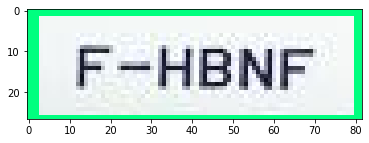

In [10]:
counter = 1
for filename in os.listdir('tail_model/output/'):
    
    IMAGE_PATH = os.path.join('tail_model/output/', filename)
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)
    
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    detection_threshold = 0.7

    image = image_np_with_detections
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]

    
    width = image.shape[1]
    height = image.shape[0]
    # Apply ROI filtering and OCR
    print('Deallocating memory')

            
    for idx, box in enumerate(boxes):
        print(box)
        roi = box*[height, width, height, width]
        print(roi)
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        
        print("Counter is ", counter)
        im = Image.fromarray(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        print("Saving the image")
        im.save("output/code%d.jpg" %(counter))
        counter = counter + 1
        print("Counter after adding is ", counter)



In [11]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [12]:
reader = easyocr.Reader(['en'])
ocr_result = reader.readtext(region)
print(ocr_result[0])
code = ocr_result[0][1]

([[11, 7], [73, 7], [73, 23], [11, 23]], 'F-HBNF', 0.8361735641679929)


In [13]:
import urllib.parse
url1 = "https://www.flightradar24.com/data/aircraft/"
final_url = urllib.parse.urljoin(url1, str(code))
print(ocr_result)
print(final_url)
webbrowser.open(final_url)

[([[11, 7], [73, 7], [73, 23], [11, 23]], 'F-HBNF', 0.8361735641679929)]
https://www.flightradar24.com/data/aircraft/F-HBNF


True